# Create clustering model(s)
- start with the "food.csv"
- tfidf vectorizer & kmeans
- combining text fields & attempting unsupervised kmeans model
- combining text fields except for 

In [1]:
# import pprint
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
# from wordcloud import WordCloud

In [2]:
food = pd.read_csv("data/foodb_2020_04_07_csv/Food.csv")
food.head(3)

,id,name,name_scientific,description,itis_id,wikipedia_id,picture_file_name,picture_content_type,picture_file_size,picture_updated_at,...,food_type,created_at,updated_at,creator_id,updater_id,export_to_afcdb,category,ncbi_taxonomy_id,export_to_foodb,public_id
0,1,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,NaN,Angelica,1.jpg,image/jpeg,111325.0,2012-04-20 09:29:57 UTC,...,Type 1,2011-02-09 00:37:14 UTC,2019-05-14 18:04:13 UTC,NaN,2.0,False,specific,357850.0,True,FOOD00001
1,2,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,NaN,Savoy cabbage,2.jpg,image/jpeg,155178.0,2012-04-20 09:39:54 UTC,...,Type 1,2011-02-09 00:37:15 UTC,2019-05-14 18:04:13 UTC,NaN,NaN,False,specific,1216010.0,True,FOOD00002
2,3,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,845789.0,Tilia tomentosa,3.jpg,image/jpeg,56367.0,2012-04-20 09:41:25 UTC,...,Type 1,2011-02-09 00:37:15 UTC,2019-05-17 16:19:45 UTC,NaN,NaN,False,specific,NaN,True,FOOD00003


In [3]:
rows = food.shape[0]
print(f"rows: {rows}")
print(f"columns: {food.columns}")

rows: 992
columns: Index(['id', 'name', 'name_scientific', 'description', 'itis_id',
       'wikipedia_id', 'picture_file_name', 'picture_content_type',
       'picture_file_size', 'picture_updated_at', 'legacy_id', 'food_group',
       'food_subgroup', 'food_type', 'created_at', 'updated_at', 'creator_id',
       'updater_id', 'export_to_afcdb', 'category', 'ncbi_taxonomy_id',
       'export_to_foodb', 'public_id'],
      dtype='object')


In [4]:
# getting rid of columns I don"t care about
drop_columns = ["id", "itis_id", "picture_file_name", "picture_content_type", "picture_file_size", "picture_updated_at", "legacy_id", "created_at", "updated_at", "creator_id",
       "updater_id", "export_to_afcdb", "category", "ncbi_taxonomy_id", "export_to_foodb", "public_id"]

print(f"keeping columns: {set(food.columns).difference(set(drop_columns))}")

keeping columns: {'food_subgroup', 'wikipedia_id', 'food_type', 'name', 'description', 'name_scientific', 'food_group'}


In [5]:
food.drop(columns=drop_columns, inplace=True)
food.head(3)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type
0,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1
1,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages,Type 1
2,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs,Type 1


In [6]:
null_count = {}
for col in food.columns:
    null_count[col] = round(food[col].isna().sum()/rows, 4)
    
null_count

{'name': 0.0,
 'name_scientific': 0.3196,
 'description': 0.0474,
 'wikipedia_id': 0.1401,
 'food_group': 0.003,
 'food_subgroup': 0.0071,
 'food_type': 0.0}

In [7]:
food.dropna(subset=["description"], inplace=True)
food.shape

(945, 7)

In [8]:
food.loc[food["food_type"] == "Type 1"].head(20)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type
0,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Type 1
1,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages,Type 1
2,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs,Type 1
3,Kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,Type 1
4,Allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Type 1
5,Garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,Onion,Vegetables,Onion-family vegetables,Type 1
6,Leek,Allium porrum,"The leek is a vegetable that belongs, along wi...",Leek,Vegetables,Onion-family vegetables,Type 1
7,Garlic,Allium sativum,"With a history of human use of over 7,000 year...",Garlic,Herbs and Spices,Herbs,Type 1
8,Chives,Allium schoenoprasum,Chives is the common name of Allium schoenopra...,Chives,Herbs and Spices,Herbs,Type 1
9,Lemon verbena,Aloysia triphylla,Aloysia citrodora is a species of flowering pl...,Aloysia citrodora,Herbs and Spices,Herbs,Type 1


In [9]:
food.loc[food["food_type"] == "Type 2"].head(20)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,food_type
267,Beer,NaN,Beer is an alcoholic beverage produced by the ...,Beer,Beverages,Fermented beverages,Type 2
268,Other bread,NaN,"Bread is the staple food in Europe, European-d...",Bread,Cereals and cereal products,Other breads,Type 2
269,Breakfast cereal,NaN,A breakfast cereal (or just cereal) is a food ...,Breakfast cereal,Cereals and cereal products,Cereal products,Type 2
272,Pasta,NaN,Pasta is a type of noodle and is a staple food...,Pasta,Cereals and cereal products,Cereal products,Type 2
273,Biscuit,NaN,"A biscuit is a baked, commonly flour-based foo...",Biscuit,Cereals and cereal products,Cereal products,Type 2
274,Sourdough,NaN,Sourdough is a dough containing a Lactobacillu...,Sourdough,Cereals and cereal products,Doughs,Type 2
276,Fortified wine,NaN,Fortified wine is wine with an added distilled...,Fortified wine,Beverages,Fortified wines,Type 2
611,Grape wine,NaN,Wine is an alcoholic beverage made from fermen...,Grape_wine,Beverages,Fermented beverages,Type 2
614,Apple cider,NaN,Apple cider (also called sweet cider or soft c...,Apple_cider,Beverages,Fermented beverages,Type 2
615,Liquor,NaN,"A distilled beverage, spirit, liquor, or hard ...",Liquor,Beverages,Distilled beverages,Type 2


In [10]:
food["food_type"].value_counts()

food_type
Type 1     693
Type 2     235
Unknown     17
Name: count, dtype: int64

In [11]:
food.loc[(food["food_type"] == "Type 2") & (food["name_scientific"].isna())].shape

(232, 7)

In [12]:
food.loc[(food["food_type"] == "Type 1") & (food["name_scientific"].isna())].shape

(34, 7)

- So *most* of the scientific names for "Type 2" foods are null and *few* are null for "Type 1" foods...
- They don"t mention the "food_type" field on their [schema reference](https://foodb.ca/schema) page so I don"t know exactly how they"ve arrived at these labels. In that display of the first 20 rows where `food_type == "Type 2"` they"re mostly manufactured foods like beer, bread & breakfast cereal but then there"s also honey so maybe they"re counting bees as cooks?
- whatever that label means, I"m going to leave it out

In [13]:
food.drop(columns=["food_type"], axis=1, inplace=True)
food.columns

Index(['name', 'name_scientific', 'description', 'wikipedia_id', 'food_group',
       'food_subgroup'],
      dtype='object')

In [14]:
# get rid of those "nan" values prior to combining all the text
food.fillna("", inplace=True)

# source: https://sparkbyexamples.com/pandas/pandas-combine-two-columns-of-text-in-dataframe/
food["all_text"] = food[food.columns].apply(" ".join, axis=1)
food["all_text"].head(5)

0    Angelica Angelica keiskei Angelica is a genus ...
1    Savoy cabbage Brassica oleracea var. sabauda S...
2    Silver linden Tilia argentea Tilia tomentosa (...
3    Kiwi Actinidia chinensis The kiwifruit, often ...
4    Allium Allium Allium haematochiton is a specie...
Name: all_text, dtype: object

---
## TFIDF Vectorizer & unsupervised KMeans
- let's see how we do if we just throw the text in "food_group" and "food_subgroup" into a block with all the other text fields

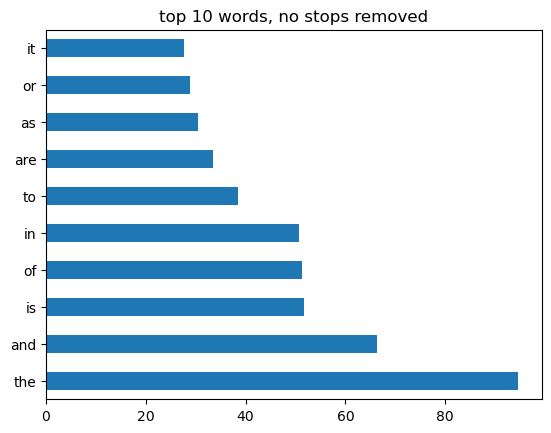

In [15]:
tvec = TfidfVectorizer()  # starting with the defaults
tvec_df = pd.DataFrame(tvec.fit_transform(food["all_text"]).todense(), columns=tvec.get_feature_names_out())

# plot top occuring words
tvec_df.sum().sort_values(ascending=False).head(10).plot(kind="barh", title="top 10 words, no stops removed");

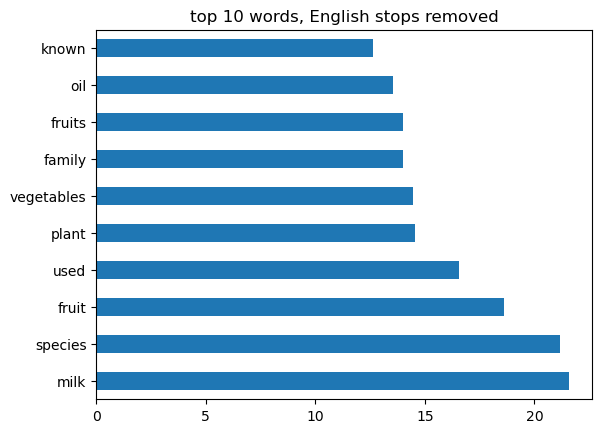

In [16]:
tvec_1 = TfidfVectorizer(stop_words="english")
tvec_df_1 = pd.DataFrame(tvec_1.fit_transform(food["all_text"]).todense(), columns=tvec_1.get_feature_names_out())

# plot top occuring words
tvec_df_1.sum().sort_values(ascending=False).head(10).plot(kind="barh", title="top 10 words, English stops removed");

In [17]:
# these next cells about kmeans are based on lesson 2.21
km = KMeans(n_init="auto", random_state=42)
km.fit(tvec_df_1)

KMeans(random_state=42)

In [18]:
# 8 is the default for `n_clusters`
len(km.cluster_centers_)

8

In [19]:
food["cluster"] = km.labels_
food.head(10)

,name,name_scientific,description,wikipedia_id,food_group,food_subgroup,all_text,cluster
0,Angelica,Angelica keiskei,Angelica is a genus of about 60 species of tal...,Angelica,Herbs and Spices,Herbs,Angelica Angelica keiskei Angelica is a genus ...,5
1,Savoy cabbage,Brassica oleracea var. sabauda,Savoy cabbage (Brassica oleracea convar. capit...,Savoy cabbage,Vegetables,Cabbages,Savoy cabbage Brassica oleracea var. sabauda S...,4
2,Silver linden,Tilia argentea,Tilia tomentosa (Silver Lime in the UK and Sil...,Tilia tomentosa,Herbs and Spices,Herbs,Silver linden Tilia argentea Tilia tomentosa (...,5
3,Kiwi,Actinidia chinensis,"The kiwifruit, often shortened to kiwi in many...",Kiwifruit,Fruits,Tropical fruits,"Kiwi Actinidia chinensis The kiwifruit, often ...",2
4,Allium,Allium,Allium haematochiton is a species of wild onio...,Allium haematochiton,Vegetables,Onion-family vegetables,Allium Allium Allium haematochiton is a specie...,5
5,Garden onion,Allium cepa,The onion (Allium cepa) (Latin 'cepa' = onion)...,Onion,Vegetables,Onion-family vegetables,Garden onion Allium cepa The onion (Allium cep...,5
6,Leek,Allium porrum,"The leek is a vegetable that belongs, along wi...",Leek,Vegetables,Onion-family vegetables,Leek Allium porrum The leek is a vegetable tha...,5
7,Garlic,Allium sativum,"With a history of human use of over 7,000 year...",Garlic,Herbs and Spices,Herbs,Garlic Allium sativum With a history of human ...,4
8,Chives,Allium schoenoprasum,Chives is the common name of Allium schoenopra...,Chives,Herbs and Spices,Herbs,Chives Allium schoenoprasum Chives is the comm...,5
9,Lemon verbena,Aloysia triphylla,Aloysia citrodora is a species of flowering pl...,Aloysia citrodora,Herbs and Spices,Herbs,Lemon verbena Aloysia triphylla Aloysia citrod...,5


In [20]:
food["cluster"].value_counts(normalize=True)

cluster
5    0.275132
4    0.192593
0    0.143915
2    0.128042
1    0.123810
7    0.070899
3    0.043386
6    0.022222
Name: proportion, dtype: float64

In [21]:
food.loc[food["cluster"] == 6][["name", "description"]].head(20)
# aside from jicama, which I don't think I would have grouped with legumes, these top 20 seem legit

,name,description
46,Chickpea,The chickpea (Cicer arietinum) is a legume of ...
84,Soy bean,The soybean (US) or soya bean (UK) (Glycine ma...
131,Scarlet bean,"Phaseolus coccineus, known as runner bean, sca..."
132,Lima bean,Phaseolus lunatus is a legume. It is grown for...
133,Common bean,"Phaseolus vulgaris, the common bean, string be..."
196,Broad bean,"Vicia faba, also known as the broad bean, fava..."
197,Adzuki bean,"The azuki bean, also known as adzuki or aduki,..."
198,Gram bean,"Vigna mungo, known as Urad Dal, black gram, bl..."
199,Mung bean,The mung or moong bean (also known as green gr...
380,Hyacinth bean,"Lablab purpureus, commonly known as the hyacin..."


In [22]:
km.inertia_

893.3201000631061

In [23]:
silhouette_score(tvec_df_1, km.labels_)

0.014305703070228857

### observations on first iteration
- high inertia
- low silhouette score 

## grid search

In [24]:
stops = list(TfidfVectorizer(stop_words="english").get_stop_words())

pipe_params = {
    "tfidf__stop_words": [None, stops],
    "tfidf__max_features": [None, 250, 300],
    "tfidf__min_df": [1, 0.01, 0.05],
    "tfidf__max_df": [1.0, 0.98, 0.95, 0.9],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "kmeans__n_clusters": range(3,11)
}

pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("kmeans", KMeans(n_init="auto"))])

- see [sklearn docs](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for available scorers
- the problem with all of these scorers is that they require "true" labels & this is unsupervised so I'm making a manual grid search; this also comes from lesson 2.21
- variations I've tried that didn't have any/much effect on the scores or that generated low enough scores that I left them out of further iterations:
    - <u>kmeans params</u>: 
        - low values for `k` were consistently worse than higher values; I initially started with `k=range(3,11)`
        - `algorithm="elkan"` generated the same scores as the default `algorithm="lloyd`
    - <u>tfidf params</u>:
        - no stop words: the max silhouette score was consistently vectorized with stop words

In [25]:
scores_no_stops = []
for k in range(3, 21):
    vect = TfidfVectorizer()  # defaults again
    vect_df = pd.DataFrame(vect.fit_transform(food["all_text"]).todense(), columns=vect.get_feature_names_out())
    
    model = KMeans(n_clusters=k, n_init="auto", random_state=42)
    model.fit(vect_df)
    
    score = silhouette_score(vect_df, model.labels_)
    scores_no_stops.append([k, model.inertia_, score])

In [26]:

scores_df = pd.DataFrame(scores_no_stops, columns=["k", "inertia", "silhouette_score"])

In [27]:
scores_df.tail()

,k,inertia,silhouette_score
13,16,837.896867,0.019994
14,17,833.508423,0.022007
15,18,830.900203,0.022680
16,19,828.100412,0.023038
17,20,824.248783,0.024871


In [28]:
def custom_kmeans_grid_search(data: pd.Series, clusters: list[int], stops=[None, "english"]) -> pd.DataFrame:
    scores = []
    for option in stops:
        vect = TfidfVectorizer(stop_words=option)
        vect_df = pd.DataFrame(vect.fit_transform(data).todense(), columns=vect.get_feature_names_out())
        
        for k in clusters:
            model = KMeans(n_clusters=k, n_init="auto", random_state=42)
            model.fit(vect_df)
            
            score = silhouette_score(vect_df, model.labels_)
            scores.append([option, k, model.inertia_, score])
    
    return pd.DataFrame(scores, columns=["stop_words", "k", "inertia", "silhouette_score"])

In [29]:
trial_1 = custom_kmeans_grid_search(food["all_text"], clusters=range(20, 31), stops=pipe_params["tfidf__stop_words"])

In [30]:
trial_1.loc[trial_1["silhouette_score"] == max(trial_1["silhouette_score"])]

,stop_words,k,inertia,silhouette_score
20,"[hers, take, give, so, now, here, three, anywh...",29,839.202973,0.027072


In [31]:
trial_2 = custom_kmeans_grid_search(food["all_text"], clusters=range(30, 46), stops=[stops])
trial_2.loc[trial_2["silhouette_score"] == max(trial_2["silhouette_score"])]

,stop_words,k,inertia,silhouette_score
2,"[hers, take, give, so, now, here, three, anywh...",32,832.743965,0.02704
